Importing Libraries

In [1]:
!pip install -qU langsmith langchain-core langchain-community langchain-openai langchain-qdrant chainlit
!pip install -qU pymupdf ragas huggingface_hub nbformat sentence-transformers torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 kB 2.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ragas 0.1.20 requires langchain-core<0.3, but you have langchain-core 0.3.5 which is incompatible.


In [2]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Qdrant
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA
from langchain.schema import Document

In [3]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


In [4]:
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass('Enter your LangSmith API key: ')


Enter your LangSmith API key: ··········


TASK 1: Dealing with the Data

In [5]:
from langchain_community.document_loaders import PyMuPDFLoader

# Load the first document
documents1 = PyMuPDFLoader(file_path="https://www.whitehouse.gov/wp-content/uploads/2022/10/Blueprint-for-an-AI-Bill-of-Rights.pdf").load()

# Load the second document
documents2 = PyMuPDFLoader(file_path="https://nvlpubs.nist.gov/nistpubs/ai/NIST.AI.600-1.pdf").load()

Chunking the Data and Splitting

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

CHUNK_SIZE = 400
CHUNK_OVERLAP = 50

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP,

)

documents1 = text_splitter.split_documents(documents1)
documents2 = text_splitter.split_documents(documents2)


In [7]:
len(documents1)

676

In [8]:
len(documents2)

486

Text Embedding Model to create Vector Store

In [9]:
from langchain_openai import OpenAIEmbeddings

EMBEDDING_MODEL = "text-embedding-3-small"

embeddings = OpenAIEmbeddings(
    model=EMBEDDING_MODEL,
    openai_api_key=os.environ["OPENAI_API_KEY"]
)

Setting up Qdrant Vector Store

In [10]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

LOCATION = ":memory:"
COLLECTION_NAME = "ai_ethics_docs"
VECTOR_SIZE = 1536

Loading the Data into Qdrant Vector Store

In [11]:
qdrant_client = QdrantClient(
    location=LOCATION
)

qdrant_client.create_collection(
    collection_name=COLLECTION_NAME,
    vectors_config=VectorParams(size=VECTOR_SIZE, distance=Distance.COSINE)
)

qdrant_vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=COLLECTION_NAME,
    embedding=embeddings
)

qdrant_vector_store.add_documents(documents1)
qdrant_vector_store.add_documents(documents2)

['f8bbf9625cc747f0a95389bd1b2a9a8c',
 '6329b7c1c22343369232001cbc083c92',
 'ec4434a1d4de442ea7d034dab929e931',
 '9c1a161dbe7149dfbf7bae7f8b54406f',
 '126961906d754d00b26f5abcda607085',
 '73e0964f87234ed3aedaa9c5f1b23fdd',
 '09ff58f721a342319d2f435e02018bf8',
 '3450c12d45d24b4383a584f6541ad97e',
 'd85dba812e9f4253bbfec42a5793de61',
 'ade0d89b50434b5285ac084f2a1a16fe',
 'fca0e7593de54d8aab0b93c573c7ada1',
 'b5f89e968b924cdd92afcc7a25ee6e74',
 '87ebac27a40840c08e535430ad335fe0',
 '4e819f668375400ba12c1c9a54c40868',
 'fab27e744af544ce90f2ae3ceb6a2f16',
 '83034461c3ce40d5afed2c4094e284ab',
 '66ea5e97dd3c43a095702ab41edaf4b9',
 '1bd0db00fd49433d8567cca55af8b5d4',
 '48d4d30e511242ffa47a8483c55f8470',
 '9925872fca634341a86bc63728f3f592',
 'adf4c0e31ec042b59a236e23a0f36a4b',
 '82a8e5e448384bddaf338f3cb7cba5be',
 '814306904d724c0ca1e8fdaa6175ea4e',
 '5d4ec279ed7946d8be3820e8aeea19e2',
 '5add2380db024810839d6840ccf4321d',
 '2783227a54584836b83827f6f9eb532e',
 'b6669050685940718a7d4c8b4e70b172',
 

TASK 2: RAG Prototype

Setting up the Retriever

In [12]:
retriever = qdrant_vector_store.as_retriever()

retrieved_documents = retriever.invoke("How can I cause no harm with AI?")

for doc in retrieved_documents:
  print(doc)

page_content='prevent future occurrences. Conduct post-mortem analyses of incidents with 
relevant AI Actors, to understand the root causes and implement preventive 
measures. 
Human-AI Conﬁguration; 
Dangerous, Violent, or Hateful 
Content 
MG-4.2-003 Use visualizations or other methods to represent GAI model behavior to ease 
non-technical stakeholders understanding of GAI system functionality.' metadata={'source': 'https://nvlpubs.nist.gov/nistpubs/ai/NIST.AI.600-1.pdf', 'file_path': 'https://nvlpubs.nist.gov/nistpubs/ai/NIST.AI.600-1.pdf', 'page': 48, 'total_pages': 64, 'format': 'PDF 1.6', 'title': 'Artificial Intelligence Risk Management Framework: Generative Artificial Intelligence Profile', 'author': 'National Institute of Standards and Technology', 'subject': '', 'keywords': '', 'creator': 'Acrobat PDFMaker 24 for Word', 'producer': 'Adobe PDF Library 24.2.159', 'creationDate': "D:20240805141702-04'00'", 'modDate': "D:20240805143048-04'00'", 'trapped': '', '_id': '4e6cbf72c2d8

Creating the RAG Chain

In [13]:
from langchain import hub

retrieval_qa_prompt = hub.pull("langchain-ai/retrieval-qa-chat")

print(retrieval_qa_prompt.messages[0].prompt.template)


Answer any use questions based solely on the context below:

<context>
{context}
</context>


In [14]:
from langchain.prompts import ChatPromptTemplate

template = """
You are a helpful assistant. Act as an AI ethics expert and answer the question in a succinct way.
If you cannot answer the question based on the context - you must say "I don't know".

Question:
{question}

Context:
{context}
"""

prompt = ChatPromptTemplate.from_template(template)

In [15]:
from operator import itemgetter

from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

primary_qa_llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

retrieval_augmented_qa_chain = (
    {
        "context": itemgetter("question") | retriever,
        "question": itemgetter("question")
    }
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {
        "response": prompt | primary_qa_llm,
        "context": itemgetter("context")
    }
)

In [16]:
# Example query
query = "How do cause no harm with AI?"
response = retrieval_augmented_qa_chain.invoke({"question": query})
print(response["response"].content)

To cause no harm with AI, it is essential to implement policies and procedures that address AI risks, manage harmful biases, enhance privacy, ensure safety and security, and conduct thorough impact assessments. Additionally, engaging in post-mortem analyses of incidents can help identify root causes and prevent future occurrences.


In [17]:
#Example query 2

query = "What is a rule of thumb for data governance?"
response = retrieval_augmented_qa_chain.invoke({"question": query})
print(response["response"].content)

A rule of thumb for data governance is to ensure data quality and maintain transparency regarding the origin and history of data, especially in sensitive domains, to avoid adverse consequences from flawed or inaccurate data.


Deploying the RAG Prototype to Hugging Face - DONE


TASK 3: Creating Test Data

In [18]:
eval_documents = PyMuPDFLoader(file_path="https://www.whitehouse.gov/wp-content/uploads/2022/10/Blueprint-for-an-AI-Bill-of-Rights.pdf").load() + \
                 PyMuPDFLoader(file_path="https://nvlpubs.nist.gov/nistpubs/ai/NIST.AI.600-1.pdf").load()

text_splitter_eval = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50
)

eval_documents = text_splitter_eval.split_documents(eval_documents)

In [19]:
len(eval_documents)

910

In [21]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

generator_llm = ChatOpenAI(model="gpt-3.5-turbo")
critic_llm = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings()

generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

distributions = {
    simple: 0.5,
    multi_context: 0.4,
    reasoning: 0.1
}

num_qa_pairs = 40 # You can reduce the number of QA pairs if you're experiencing rate-limiting issues

testset = generator.generate_with_langchain_docs(eval_documents, num_qa_pairs, distributions)

testset.to_pandas()


embedding nodes:   0%|          | 0/1820 [00:00<?, ?it/s]

Generating:   0%|          | 0/40 [00:00<?, ?it/s]

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,What reports must be filed by the Department o...,[the Department of Labor Office of Labor-Manag...,Reports regarding their activities must be fil...,simple,[{'source': 'https://www.whitehouse.gov/wp-con...,True
1,"How can potential content provenance harms, su...",[data generation capabilities for potential mi...,"Potential content provenance harms, such as mi...",simple,[{'source': 'https://nvlpubs.nist.gov/nistpubs...,True
2,How does the Blueprint for an AI Bill of Right...,[- \nUSING THIS TECHNICAL COMPANION\nThe Bl...,The Blueprint for an AI Bill of Rights aims to...,simple,[{'source': 'https://www.whitehouse.gov/wp-con...,True
3,What is the importance of directly engaging di...,[maintenance phases of automated system develo...,The importance of directly engaging diverse im...,simple,[{'source': 'https://www.whitehouse.gov/wp-con...,True
4,How does the use of personal data for GAI trai...,[some cases may include personal data. The use...,The use of personal data for GAI training rais...,simple,[{'source': 'https://nvlpubs.nist.gov/nistpubs...,True
5,What is the purpose of AI red-teaming in ident...,"[subjects research requirements, and best prac...",AI red-teaming is a practice that involves con...,simple,[{'source': 'https://nvlpubs.nist.gov/nistpubs...,True
6,What legal requirements and oversight are in p...,[tion or implemented under existing U.S. laws....,"Government surveillance, data search, and seiz...",simple,[{'source': 'https://www.whitehouse.gov/wp-con...,True
7,What information should be included in regular...,[be revoked without reasonable and verified ju...,Entities responsible for the development or us...,simple,[{'source': 'https://www.whitehouse.gov/wp-con...,True
8,How should data from sensitive domains like cr...,[in the spreading and scaling of harms. Data f...,Data from sensitive domains like criminal just...,simple,[{'source': 'https://www.whitehouse.gov/wp-con...,True
9,How do virtual or augmented reality workplace ...,[Employment-related systems such as workplace ...,Virtual or augmented reality workplace trainin...,simple,[{'source': 'https://www.whitehouse.gov/wp-con...,True


In [22]:
testset.test_data[0]

DataRow(question='What reports must be filed by the Department of Labor Office of Labor-Management Standards and consultants retained by employers for these purposes?', contexts=['the Department of Labor Office of Labor-Management Standards, and consultants who employers retain for \nthese purposes must also file reports regarding their activities.81\nPrivacy choices on smartphones show that when technologies are well designed, privacy \nand data agency can be meaningful and not overwhelming. These choices—such as contextual, timely \nalerts about location tracking—are brief, direct, and use-specific. Many of the expectations listed here for'], ground_truth='Reports regarding their activities must be filed by the Department of Labor Office of Labor-Management Standards and consultants retained by employers for these purposes.', evolution_type='simple', metadata=[{'source': 'https://www.whitehouse.gov/wp-content/uploads/2022/10/Blueprint-for-an-AI-Bill-of-Rights.pdf', 'file_path': 'http

In [23]:
testset_df = testset.to_pandas()
testset_df.to_csv("synthetic_data.csv")

In [24]:
import pandas as pd

test_df = pd.read_csv("synthetic_data.csv")

In [25]:
testset_df

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,What reports must be filed by the Department o...,[the Department of Labor Office of Labor-Manag...,Reports regarding their activities must be fil...,simple,[{'source': 'https://www.whitehouse.gov/wp-con...,True
1,"How can potential content provenance harms, su...",[data generation capabilities for potential mi...,"Potential content provenance harms, such as mi...",simple,[{'source': 'https://nvlpubs.nist.gov/nistpubs...,True
2,How does the Blueprint for an AI Bill of Right...,[- \nUSING THIS TECHNICAL COMPANION\nThe Bl...,The Blueprint for an AI Bill of Rights aims to...,simple,[{'source': 'https://www.whitehouse.gov/wp-con...,True
3,What is the importance of directly engaging di...,[maintenance phases of automated system develo...,The importance of directly engaging diverse im...,simple,[{'source': 'https://www.whitehouse.gov/wp-con...,True
4,How does the use of personal data for GAI trai...,[some cases may include personal data. The use...,The use of personal data for GAI training rais...,simple,[{'source': 'https://nvlpubs.nist.gov/nistpubs...,True
5,What is the purpose of AI red-teaming in ident...,"[subjects research requirements, and best prac...",AI red-teaming is a practice that involves con...,simple,[{'source': 'https://nvlpubs.nist.gov/nistpubs...,True
6,What legal requirements and oversight are in p...,[tion or implemented under existing U.S. laws....,"Government surveillance, data search, and seiz...",simple,[{'source': 'https://www.whitehouse.gov/wp-con...,True
7,What information should be included in regular...,[be revoked without reasonable and verified ju...,Entities responsible for the development or us...,simple,[{'source': 'https://www.whitehouse.gov/wp-con...,True
8,How should data from sensitive domains like cr...,[in the spreading and scaling of harms. Data f...,Data from sensitive domains like criminal just...,simple,[{'source': 'https://www.whitehouse.gov/wp-con...,True
9,How do virtual or augmented reality workplace ...,[Employment-related systems such as workplace ...,Virtual or augmented reality workplace trainin...,simple,[{'source': 'https://www.whitehouse.gov/wp-con...,True


In [26]:
test_questions = testset_df["question"].values.tolist()
test_groundtruths = testset_df["ground_truth"].values.tolist()


In [27]:
answers = []
contexts = []

for question in test_questions:
    response = retrieval_augmented_qa_chain.invoke({"question": question})
    answers.append(response["response"].content)
    contexts.append([context.page_content for context in response["context"]])



In [28]:
from datasets import Dataset

min_length = min(len(test_questions[:10]), len(answers[:10]), len(contexts[:10]), len(test_groundtruths[:10]))

response_dataset = Dataset.from_dict({
    "question": test_questions[:min_length],
    "answer": answers[:min_length],
    "contexts": contexts[:min_length],
    "ground_truth": test_groundtruths[:min_length]
})

In [29]:
response_dataset[0]

{'question': 'What reports must be filed by the Department of Labor Office of Labor-Management Standards and consultants retained by employers for these purposes?',
 'answer': 'Employers engaging in workplace surveillance related to labor disputes must report expenditures to the Department of Labor Office of Labor-Management Standards. Additionally, consultants retained by employers for these purposes are also required to file reports regarding their activities.',
 'contexts': ['labor organization in connection with a labor dispute" must report expenditures relating to this surveillance to \nthe Department of Labor Office of Labor-Management Standards, and consultants who employers retain for \nthese purposes must also file reports regarding their activities.81\nPrivacy choices on smartphones show that when technologies are well designed, privacy',
  'https://nyassembly.gov/leg/?default_fld=&leg_video=&bn=S05140&term=2019&Summary=Y&Text=Y\n81. U.S Department of Labor. Labor-Management 

Assess your pipeline using the RAGAS framework including key metrics faithfulness, answer relevancy, context precision, and context recall.

In [30]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    answer_correctness,
    context_recall,
    context_precision,
)

metrics = [
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness,
]

In [31]:
# Evaluate the first dataset
results1 = evaluate(response_dataset, metrics)

# Print the results
print("Results for dataset:")
print(results1)

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

Results for dataset:
{'faithfulness': 0.7752, 'answer_relevancy': 0.8536, 'context_recall': 0.8333, 'context_precision': 0.8639, 'answer_correctness': 0.7448}


Conclusions: the dataset does pretty well on all the parameters. Interesting thing to note is that scores on answer relevancy were low when I had created a test set with only 10 samples


**TASK 4: Fine-tuning the Embeddings**

Generate synthetic fine-tuning data and complete fine-tuning of the open-source embedding model

Step 1: Create Training, Validation, and Test Datasets
We'll split the documents into training, validation, and test sets for both datasets.

In [81]:
documents = documents1 + documents2

In [82]:
len(documents)

1162

In [101]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 400,
    chunk_overlap  = 50,
    length_function = len
)

In [102]:
training_documents = text_splitter.split_documents(documents)

In [103]:
len(training_documents)

1162

In [104]:
import uuid

id_set = set()

for document in training_documents:
  id = str(uuid.uuid4())
  while id in id_set:
    id = uuid.uuid4()
  id_set.add(id)
  document.metadata["id"] = id

In [105]:
training_split_documents = training_documents[:300]
val_split_documents = training_documents[300:350]
test_split_documents = training_documents[350:400]

In [106]:
import json
from tqdm import tqdm
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

# Initialize the ChatOpenAI model
qa_chat_model = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

# Create the custom question generation prompt
qa_prompt = """\
You are an AI ethics expert. Generate {n_questions} questions that could be answered based on the following context. The questions should be related to AI ethics and should be answerable in a succinct way.

If a question cannot be directly answered based solely on the given context, do not include it.

Provide the questions in the following format:
1. QUESTION #1
2. QUESTION #2
...

Context:
{context}
"""

qa_prompt_template = ChatPromptTemplate.from_template(qa_prompt)

# Create the question generation chain
question_generation_chain = qa_prompt_template | qa_chat_model

# Custom prompt for the RAG chain
rag_template = """
You are a helpful assistant. Act as an AI ethics expert and answer the question in a succinct way.
If you cannot answer the question based on the context - you must say "I don't know".

Question:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(rag_template)


In [107]:
def create_questions(documents, n_questions):
    questions = {}
    relevant_docs = {}

    for doc in tqdm(documents):
        doc_id = doc.metadata["id"]
        context = doc.page_content

        # Generate questions using the question generation chain
        generated_questions = question_generation_chain.invoke({
            "context": context,
            "n_questions": n_questions
        }).content

        # Parse the generated questions
        for i, question in enumerate(generated_questions.split('\n')):
            if question.strip():
                question_id = f"{doc_id}_{i+1}"
                questions[question_id] = question.split('. ', 1)[1]  # Remove the number prefix
                relevant_docs[question_id] = [doc_id]

    return questions, relevant_docs


In [108]:
training_questions, training_relevant_contexts = create_questions(training_split_documents, n_questions=2)

100%|██████████| 300/300 [04:36<00:00,  1.09it/s]


In [109]:
val_questions, val_relevant_contexts = create_questions(val_split_documents, n_questions=2)

100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


In [110]:
test_questions, test_relevant_contexts = create_questions(test_split_documents, n_questions=2)

100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


In [111]:
def generate_and_save_dataset(documents, n_questions, filename):
    questions, relevant_contexts = create_questions(documents, n_questions)
    corpus = {doc.metadata["id"]: doc.page_content for doc in documents}

    dataset = {
        "questions": questions,
        "relevant_contexts": relevant_contexts,
        "corpus": corpus,
        "rag_prompt": rag_template  # Include the RAG prompt in the dataset
    }

    with open(filename, "w") as f:
        json.dump(dataset, f)

    print(f"Dataset saved to {filename}")


In [112]:
# Generate and save training dataset
generate_and_save_dataset(training_split_documents, n_questions=2, filename="training_dataset.jsonl")

# Generate and save validation dataset
generate_and_save_dataset(val_split_documents, n_questions=2, filename="val_dataset.jsonl")

# Generate and save test dataset
generate_and_save_dataset(test_split_documents, n_questions=2, filename="test_dataset.jsonl")

100%|██████████| 300/300 [04:47<00:00,  1.04it/s]


Dataset saved to training_dataset.jsonl


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Dataset saved to val_dataset.jsonl


100%|██████████| 50/50 [00:45<00:00,  1.11it/s]

Dataset saved to test_dataset.jsonl


In [113]:
import json

training_corpus = {train_item.metadata["id"] : train_item.page_content for train_item in training_split_documents}

train_dataset = {
    "questions" : training_questions,
    "relevant_contexts" : training_relevant_contexts,
    "corpus" : training_corpus
}

with open("training_dataset.jsonl", "w") as f:
  json.dump(train_dataset, f)

In [114]:
val_corpus = {val_item.metadata["id"] : val_item.page_content for val_item in val_split_documents}

val_dataset = {
    "questions" : val_questions,
    "relevant_contexts" : val_relevant_contexts,
    "corpus" : val_corpus
}

with open("val_dataset.jsonl", "w") as f:
  json.dump(val_dataset, f)

In [115]:
test_corpus = {test_item.metadata["id"] : test_item.page_content for test_item in test_split_documents}

test_dataset = {
    "questions" : test_questions,
    "relevant_contexts" : test_relevant_contexts,
    "corpus" : test_corpus
}

with open("test_dataset.jsonl", "w") as f:
  json.dump(test_dataset, f)

Step 2 - Fine tuning the Embedding Model on our Dataset

In [49]:
!pip install -qU sentence_transformers datasets pyarrow

In [116]:
from sentence_transformers import SentenceTransformer

from google.colab import userdata
userdata.get('HF_TOKEN')

model_id = "Snowflake/snowflake-arctic-embed-m"
model = SentenceTransformer(model_id)

In [117]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sentence_transformers import InputExample

In [118]:
BATCH_SIZE = 20

In [119]:
corpus = train_dataset['corpus']
queries = train_dataset['questions']
relevant_docs = train_dataset['relevant_contexts']

examples = []
for query_id, query in queries.items():
    doc_id = relevant_docs[query_id][0]
    text = corpus[doc_id]
    example = InputExample(texts=[query, text])
    examples.append(example)

In [120]:
loader = DataLoader(
    examples, batch_size=BATCH_SIZE
)

In [121]:
from sentence_transformers.losses import MatryoshkaLoss, MultipleNegativesRankingLoss

matryoshka_dimensions = [768, 512, 256, 128, 64]
inner_train_loss = MultipleNegativesRankingLoss(model)
train_loss = MatryoshkaLoss(
    model, inner_train_loss, matryoshka_dims=matryoshka_dimensions
)

In [122]:
from sentence_transformers.evaluation import InformationRetrievalEvaluator

corpus = val_dataset['corpus']
queries = val_dataset['questions']
relevant_docs = val_dataset['relevant_contexts']

evaluator = InformationRetrievalEvaluator(queries, corpus, relevant_docs)

In [123]:
EPOCHS = 5

In [124]:
warmup_steps = int(len(loader) * EPOCHS * 0.1)

model.fit(
    train_objectives=[(loader, train_loss)],
    epochs=EPOCHS,
    warmup_steps=warmup_steps,
    output_path='finetuned_arctic',
    show_progress_bar=True,
    evaluator=evaluator,
    evaluation_steps=50,
)

Step,Training Loss,Validation Loss,Cosine Accuracy@1,Cosine Accuracy@3,Cosine Accuracy@5,Cosine Accuracy@10,Cosine Precision@1,Cosine Precision@3,Cosine Precision@5,Cosine Precision@10,Cosine Recall@1,Cosine Recall@3,Cosine Recall@5,Cosine Recall@10,Cosine Ndcg@10,Cosine Mrr@10,Cosine Map@100,Dot Accuracy@1,Dot Accuracy@3,Dot Accuracy@5,Dot Accuracy@10,Dot Precision@1,Dot Precision@3,Dot Precision@5,Dot Precision@10,Dot Recall@1,Dot Recall@3,Dot Recall@5,Dot Recall@10,Dot Ndcg@10,Dot Mrr@10,Dot Map@100
30,No log,No log,0.790000,0.930000,0.970000,0.990000,0.790000,0.310000,0.194000,0.099000,0.790000,0.930000,0.970000,0.990000,0.894154,0.862667,0.863083,0.790000,0.930000,0.970000,0.990000,0.790000,0.310000,0.194000,0.099000,0.790000,0.930000,0.970000,0.990000,0.894154,0.862667,0.863083
50,No log,No log,0.820000,0.950000,0.980000,0.990000,0.820000,0.316667,0.196000,0.099000,0.820000,0.950000,0.980000,0.990000,0.911285,0.885167,0.885833,0.820000,0.950000,0.980000,0.990000,0.820000,0.316667,0.196000,0.099000,0.820000,0.950000,0.980000,0.990000,0.911285,0.885167,0.885833
60,No log,No log,0.820000,0.950000,0.980000,0.990000,0.820000,0.316667,0.196000,0.099000,0.820000,0.950000,0.980000,0.990000,0.911285,0.885167,0.885833,0.820000,0.950000,0.980000,0.990000,0.820000,0.316667,0.196000,0.099000,0.820000,0.950000,0.980000,0.990000,0.911285,0.885167,0.885833
90,No log,No log,0.820000,0.950000,0.980000,0.990000,0.820000,0.316667,0.196000,0.099000,0.820000,0.950000,0.980000,0.990000,0.912595,0.886833,0.887500,0.820000,0.950000,0.980000,0.990000,0.820000,0.316667,0.196000,0.099000,0.820000,0.950000,0.980000,0.990000,0.912595,0.886833,0.887500
100,No log,No log,0.810000,0.940000,0.980000,0.990000,0.810000,0.313333,0.196000,0.099000,0.810000,0.940000,0.980000,0.990000,0.908211,0.881000,0.881667,0.810000,0.940000,0.980000,0.990000,0.810000,0.313333,0.196000,0.099000,0.810000,0.940000,0.980000,0.990000,0.908211,0.881000,0.881667
120,No log,No log,0.810000,0.940000,0.980000,0.990000,0.810000,0.313333,0.196000,0.099000,0.810000,0.940000,0.980000,0.990000,0.908211,0.881000,0.881714,0.810000,0.940000,0.980000,0.990000,0.810000,0.313333,0.196000,0.099000,0.810000,0.940000,0.980000,0.990000,0.908211,0.881000,0.881714
150,No log,No log,0.810000,0.940000,0.980000,0.990000,0.810000,0.313333,0.196000,0.099000,0.810000,0.940000,0.980000,0.990000,0.908211,0.881000,0.881714,0.810000,0.940000,0.980000,0.990000,0.810000,0.313333,0.196000,0.099000,0.810000,0.940000,0.980000,0.990000,0.908211,0.881000,0.881714


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

In [125]:
import pandas as pd

from langchain_community.vectorstores import FAISS
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.documents import Document

In [126]:
import pandas as pd
from langchain_core.documents import Document
from tqdm import tqdm
import os

from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

def setup_qdrant(documents):
    EMBEDDING_MODEL = "text-embedding-3-small"
    LOCATION = ":memory:"
    COLLECTION_NAME = "ai_ethics_docs"
    VECTOR_SIZE = 1536

    embeddings = OpenAIEmbeddings(
        model=EMBEDDING_MODEL,
        openai_api_key=os.environ["OPENAI_API_KEY"]
    )

    qdrant_client = QdrantClient(location=LOCATION)

    qdrant_client.recreate_collection(
        collection_name=COLLECTION_NAME,
        vectors_config=VectorParams(size=VECTOR_SIZE, distance=Distance.COSINE)
    )

    qdrant_vector_store = QdrantVectorStore(
        client=qdrant_client,
        collection_name=COLLECTION_NAME,
        embedding=embeddings
    )

    qdrant_vector_store.add_documents(documents)

    return qdrant_vector_store

def evaluate_qdrant(dataset, top_k=5, verbose=False):
    corpus = dataset['corpus']
    questions = dataset['questions']
    relevant_docs = dataset['relevant_contexts']

    # Prepare documents
    documents = [Document(page_content=content, metadata={"id": doc_id}) for doc_id, content in corpus.items()]

    # Setup Qdrant and add documents
    vectorstore = setup_qdrant(documents)

    # Create retriever
    retriever = vectorstore.as_retriever(search_kwargs={"k": top_k})

    eval_results = []
    for id, question in tqdm(questions.items()):
        retrieved_nodes = retriever.invoke(question)
        retrieved_ids = [node.metadata["id"] for node in retrieved_nodes]
        expected_id = relevant_docs[id][0]
        is_hit = expected_id in retrieved_ids
        eval_results.append({"id": id, "question": question, "expected_id": expected_id, "is_hit": is_hit})

    return eval_results

In [127]:
# Usage example:
results = evaluate_qdrant(test_dataset)

results_df = pd.DataFrame(results)
hit_rate = results_df["is_hit"].mean()
print(f"Hit rate: {hit_rate}")

<ipython-input-126-da0c955f493d>:24: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant_client.recreate_collection(
100%|██████████| 100/100 [00:27<00:00,  3.64it/s]

Hit rate: 0.92


Evaluating Snowflake Base Model

In [128]:
import pandas as pd
from langchain_core.documents import Document
from tqdm import tqdm
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams, PointStruct
from sentence_transformers import SentenceTransformer
import numpy as np

def setup_qdrant_snowflake(documents):
    LOCATION = ":memory:"
    COLLECTION_NAME = "snowflake_arctic_docs"
    VECTOR_SIZE = 768  # Snowflake Arctic base model embedding size

    # Load Snowflake Arctic base model
    model = SentenceTransformer('Snowflake/snowflake-arctic-embed-m')

    qdrant_client = QdrantClient(location=LOCATION)

    # Always create a new collection for in-memory client
    qdrant_client.create_collection(
        collection_name=COLLECTION_NAME,
        vectors_config=VectorParams(size=VECTOR_SIZE, distance=Distance.COSINE)
    )

    # Embed documents and add to Qdrant
    for doc in documents:
        embedding = model.encode(doc.page_content)
        qdrant_client.upsert(
            collection_name=COLLECTION_NAME,
            points=[PointStruct(id=doc.metadata["id"], vector=embedding.tolist(), payload={"content": doc.page_content})]
        )

    return qdrant_client, COLLECTION_NAME, model

def evaluate_snowflake_arctic(dataset, top_k=5, verbose=False):
    corpus = dataset['corpus']
    questions = dataset['questions']
    relevant_docs = dataset['relevant_contexts']

    # Prepare documents
    documents = [Document(page_content=content, metadata={"id": doc_id}) for doc_id, content in corpus.items()]

    # Setup Qdrant with Snowflake Arctic embeddings and add documents
    qdrant_client, collection_name, model = setup_qdrant_snowflake(documents)

    eval_results = []
    for id, question in tqdm(questions.items()):
        query_vector = model.encode(question).tolist()
        search_result = qdrant_client.search(
            collection_name=collection_name,
            query_vector=query_vector,
            limit=top_k
        )
        retrieved_ids = [hit.id for hit in search_result]
        expected_id = relevant_docs[id][0]
        is_hit = expected_id in retrieved_ids
        eval_results.append({"id": id, "question": question, "expected_id": expected_id, "is_hit": is_hit})

    return eval_results

# Usage example:
results = evaluate_snowflake_arctic(test_dataset)

results_df = pd.DataFrame(results)
hit_rate = results_df["is_hit"].mean()
print(f"Hit rate for Snowflake Arctic base model: {hit_rate}")

100%|██████████| 100/100 [00:01<00:00, 57.20it/s]

Hit rate for Snowflake Arctic base model: 0.88


Evaluating our fine tuned model

In [129]:
import pandas as pd
from langchain_core.documents import Document
from tqdm import tqdm
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams, PointStruct
from sentence_transformers import SentenceTransformer
import numpy as np

def setup_qdrant_snowflake(documents):
    LOCATION = ":memory:"
    COLLECTION_NAME = "snowflake_arctic_docs"
    VECTOR_SIZE = 768  # Snowflake Arctic base model embedding size

    # Load Snowflake Arctic base model
    model = SentenceTransformer('finetuned_arctic')

    qdrant_client = QdrantClient(location=LOCATION)

    # Always create a new collection for in-memory client
    qdrant_client.create_collection(
        collection_name=COLLECTION_NAME,
        vectors_config=VectorParams(size=VECTOR_SIZE, distance=Distance.COSINE)
    )

    # Embed documents and add to Qdrant
    for doc in documents:
        embedding = model.encode(doc.page_content)
        qdrant_client.upsert(
            collection_name=COLLECTION_NAME,
            points=[PointStruct(id=doc.metadata["id"], vector=embedding.tolist(), payload={"content": doc.page_content})]
        )

    return qdrant_client, COLLECTION_NAME, model

def evaluate_snowflake_arctic(dataset, top_k=5, verbose=False):
    corpus = dataset['corpus']
    questions = dataset['questions']
    relevant_docs = dataset['relevant_contexts']

    # Prepare documents
    documents = [Document(page_content=content, metadata={"id": doc_id}) for doc_id, content in corpus.items()]

    # Setup Qdrant with Snowflake Arctic embeddings and add documents
    qdrant_client, collection_name, model = setup_qdrant_snowflake(documents)

    eval_results = []
    for id, question in tqdm(questions.items()):
        query_vector = model.encode(question).tolist()
        search_result = qdrant_client.search(
            collection_name=collection_name,
            query_vector=query_vector,
            limit=top_k
        )
        retrieved_ids = [hit.id for hit in search_result]
        expected_id = relevant_docs[id][0]
        is_hit = expected_id in retrieved_ids
        eval_results.append({"id": id, "question": question, "expected_id": expected_id, "is_hit": is_hit})

    return eval_results

# Usage example:
results = evaluate_snowflake_arctic(test_dataset)

results_df = pd.DataFrame(results)
hit_rate = results_df["is_hit"].mean()
print(f"Hit rate for Snowflake Arctic fine tuned model: {hit_rate}")

Some weights of BertModel were not initialized from the model checkpoint at finetuned_arctic and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 100/100 [00:01<00:00, 57.97it/s]

Hit rate for Snowflake Arctic fine tuned model: 0.98


In [135]:
from huggingface_hub import notebook_login
notebook_login()

In [136]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('finetuned_arctic')

Some weights of BertModel were not initialized from the model checkpoint at finetuned_arctic and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [139]:
arctic_finetuned_model = SentenceTransformer('finetuned_arctic')

Some weights of BertModel were not initialized from the model checkpoint at finetuned_arctic and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [140]:
arctic_finetuned_model.push_to_hub("niting089/finetuned_arctic")

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

'https://huggingface.co/niting089/finetuned_arctic/commit/a8c56912f88396be928c82b2ab65ce8935ae88e6'

In [130]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)
from datasets import Dataset
import json
from langchain_core.documents import Document
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams, PointStruct
from sentence_transformers import SentenceTransformer

metrics = [
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
]

In [131]:
# Load the test dataset
with open("test_dataset.jsonl", "r") as f:
    test_dataset = json.load(f)

def setup_qdrant_snowflake(documents):
    LOCATION = ":memory:"
    COLLECTION_NAME = "snowflake_arctic_docs"
    VECTOR_SIZE = 768  # Snowflake Arctic base model embedding size

    # Load Snowflake Arctic base model
    model = SentenceTransformer('Snowflake/snowflake-arctic-embed-m')

    qdrant_client = QdrantClient(location=LOCATION)

    # Always create a new collection for in-memory client
    qdrant_client.create_collection(
        collection_name=COLLECTION_NAME,
        vectors_config=VectorParams(size=VECTOR_SIZE, distance=Distance.COSINE)
    )

    # Embed documents and add to Qdrant
    for doc in documents:
        embedding = model.encode(doc.page_content)
        qdrant_client.upsert(
            collection_name=COLLECTION_NAME,
            points=[PointStruct(id=doc.metadata["id"], vector=embedding.tolist(), payload={"content": doc.page_content})]
        )

    return qdrant_client, COLLECTION_NAME, model


In [132]:
def evaluate_model(dataset, setup_function, top_k=5):
    corpus = dataset['corpus']
    questions = dataset['questions']
    relevant_docs = dataset['relevant_contexts']

    # Prepare documents
    documents = [Document(page_content=content, metadata={"id": doc_id}) for doc_id, content in corpus.items()]

    # Setup Qdrant with embeddings and add documents
    qdrant_client, collection_name, model = setup_function(documents)

    eval_results = []
    for id, question in questions.items():
        query_vector = model.encode(question).tolist()
        search_result = qdrant_client.search(
            collection_name=collection_name,
            query_vector=query_vector,
            limit=top_k
        )
        retrieved_ids = [hit.id for hit in search_result]
        retrieved_contexts = [corpus[doc_id] for doc_id in retrieved_ids]
        expected_id = relevant_docs[id][0]
        ground_truth = corpus[expected_id]

        eval_results.append({
            "question": question,
            "contexts": retrieved_contexts,
            "answer": "This is a placeholder answer.",  # Ragas requires a non-empty answer
            "ground_truth": ground_truth
        })

    return Dataset.from_list(eval_results)

In [133]:
# Evaluate Snowflake Arctic base model
snowflake_dataset = evaluate_model(test_dataset, setup_qdrant_snowflake)

# Run Ragas evaluation
snowflake_results = evaluate(snowflake_dataset, metrics)

print("Results for Snowflake Arctic base model:")
print(snowflake_results)


Evaluating:   0%|          | 0/400 [00:00<?, ?it/s]

Results for Snowflake Arctic base model:
{'faithfulness': 0.0000, 'answer_relevancy': 0.0000, 'context_recall': 0.8285, 'context_precision': 0.8276}


In [134]:
# Evaluate fine-tuned model
finetuned_dataset = evaluate_model(test_dataset, setup_qdrant_finetuned)

# Run Ragas evaluation for fine-tuned model
finetuned_results = evaluate(finetuned_dataset, metrics)

print("Results for fine-tuned model:")
print(finetuned_results)

Some weights of BertModel were not initialized from the model checkpoint at finetuned_arctic and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating:   0%|          | 0/400 [00:00<?, ?it/s]

Results for fine-tuned model:
{'faithfulness': 0.0000, 'answer_relevancy': 0.0000, 'context_recall': 0.8890, 'context_precision': 0.9120}


              Metric  T3 (Small)  Snowflake Base  Snowflake Fine-tuned  \
0       faithfulness    0.775198        0.000000              0.000000   
1   answer_relevancy    0.853627        0.000000              0.000000   
2     context_recall    0.833333        0.828500              0.889000   
3  context_precision    0.863889        0.827569              0.912042   

   T3 -> Snowflake Base  T3 -> Snowflake Fine-tuned  \
0             -0.775198                   -0.775198   
1             -0.853627                   -0.853627   
2             -0.004833                    0.055667   
3             -0.036319                    0.048153   

   Snowflake Base -> Fine-tuned  
0                      0.000000  
1                      0.000000  
2                      0.060500  
3                      0.084472  


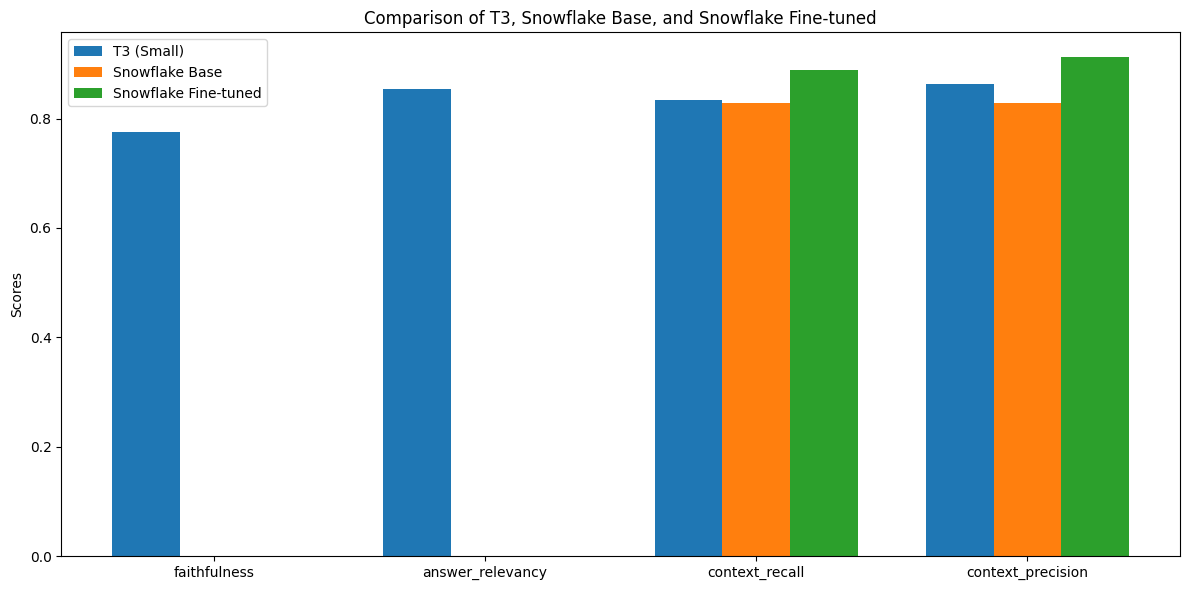

In [149]:
import pandas as pd

# Assuming you have the results for each model stored in separate variables
t3_results = results  # T3 (Text Embedding 3 - Small) results
snowflake_base_results = snowflake_results  # Base Snowflake results
snowflake_finetuned_results = finetuned_results  # Fine-tuned Snowflake results

# Create DataFrames for each model
df_t3 = pd.DataFrame(list(results1.items()), columns=['Metric', 'T3 (Small)'])
df_snowflake_base = pd.DataFrame(list(snowflake_base_results.items()), columns=['Metric', 'Snowflake Base'])
df_snowflake_finetuned = pd.DataFrame(list(snowflake_finetuned_results.items()), columns=['Metric', 'Snowflake Fine-tuned'])

# Merge the DataFrames
df_merged = pd.merge(df_t3, df_snowflake_base, on='Metric')
df_merged = pd.merge(df_merged, df_snowflake_finetuned, on='Metric')

# Calculate differences
df_merged['T3 -> Snowflake Base'] = df_merged['Snowflake Base'] - df_merged['T3 (Small)']
df_merged['T3 -> Snowflake Fine-tuned'] = df_merged['Snowflake Fine-tuned'] - df_merged['T3 (Small)']
df_merged['Snowflake Base -> Fine-tuned'] = df_merged['Snowflake Fine-tuned'] - df_merged['Snowflake Base']

# Reorder columns for better readability
column_order = ['Metric', 'T3 (Small)', 'Snowflake Base', 'Snowflake Fine-tuned',
                'T3 -> Snowflake Base', 'T3 -> Snowflake Fine-tuned', 'Snowflake Base -> Fine-tuned']
df_merged = df_merged[column_order]

# Display the results
print(df_merged)

# Optionally, you can also create a bar plot to visualize the comparison
import matplotlib.pyplot as plt

metrics = df_merged['Metric']
t3_values = df_merged['T3 (Small)']
snowflake_base_values = df_merged['Snowflake Base']
snowflake_finetuned_values = df_merged['Snowflake Fine-tuned']

x = range(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x, t3_values, width, label='T3 (Small)')
ax.bar([i + width for i in x], snowflake_base_values, width, label='Snowflake Base')
ax.bar([i + 2 * width for i in x], snowflake_finetuned_values, width, label='Snowflake Fine-tuned')

ax.set_ylabel('Scores')
ax.set_title('Comparison of T3, Snowflake Base, and Snowflake Fine-tuned')
ax.set_xticks([i + width for i in x])
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()